<a href="https://colab.research.google.com/github/illusion-master/django/blob/master/APIs/ML/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# skip first 3 cell in case u have downloaded dataset else genreate a api from kaggle and fill in username and key
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"Enter your username","key":"Enter key generated by kaggle"}
with open ('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shubhamgoel27/dermnet -p /content
!unzip \*zip


In [31]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [6]:
data = []
i =0
for folder in sorted(os.listdir('train')):
  for file in sorted(os.listdir('train/'+ folder)):
    data.append((file, folder, i))
  i = i+1

df = pd.DataFrame(data, columns=['filename', 'tags', 'type_index'])
df.to_csv('train.csv', index = False)

In [7]:
data = []
i=0
for folder in sorted(os.listdir('test')):
  for file in sorted(os.listdir('test/'+ folder)):
    data.append((file, folder, i))
  i = i+1

df = pd.DataFrame(data, columns=['filename', 'tags', 'type_index'])
df.to_csv('test.csv', index = False)

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
train['path'] = 'train/'+train['tags']+'/'+train['filename']
test['path'] = 'test/'+test['tags']+'/'+test['filename']

In [10]:
train['tags'].unique()

array(['Acne and Rosacea Photos',
       'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
       'Atopic Dermatitis Photos', 'Bullous Disease Photos',
       'Cellulitis Impetigo and other Bacterial Infections',
       'Eczema Photos', 'Exanthems and Drug Eruptions',
       'Hair Loss Photos Alopecia and other Hair Diseases',
       'Herpes HPV and other STDs Photos',
       'Light Diseases and Disorders of Pigmentation',
       'Lupus and other Connective Tissue diseases',
       'Melanoma Skin Cancer Nevi and Moles',
       'Nail Fungus and other Nail Disease',
       'Poison Ivy Photos and other Contact Dermatitis',
       'Psoriasis pictures Lichen Planus and related diseases',
       'Scabies Lyme Disease and other Infestations and Bites',
       'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease',
       'Tinea Ringworm Candidiasis and other Fungal Infections',
       'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos',
       'Warts Moll

In [11]:
for i in range(23):
  print(i, ': ', train.loc[train['type_index'] == i, ['type_index']].count())


0 :  type_index    840
dtype: int64
1 :  type_index    1149
dtype: int64
2 :  type_index    489
dtype: int64
3 :  type_index    448
dtype: int64
4 :  type_index    288
dtype: int64
5 :  type_index    1235
dtype: int64
6 :  type_index    404
dtype: int64
7 :  type_index    239
dtype: int64
8 :  type_index    405
dtype: int64
9 :  type_index    568
dtype: int64
10 :  type_index    420
dtype: int64
11 :  type_index    463
dtype: int64
12 :  type_index    1040
dtype: int64
13 :  type_index    260
dtype: int64
14 :  type_index    1405
dtype: int64
15 :  type_index    431
dtype: int64
16 :  type_index    1371
dtype: int64
17 :  type_index    606
dtype: int64
18 :  type_index    1300
dtype: int64
19 :  type_index    212
dtype: int64
20 :  type_index    482
dtype: int64
21 :  type_index    416
dtype: int64
22 :  type_index    1086
dtype: int64


In [12]:
train = train.drop(train.loc[train['type_index'] == 1].index)
train = train.drop(train.loc[train['type_index'] == 2].index)
train = train.drop(train.loc[train['type_index'] == 3].index)
train = train.drop(train.loc[train['type_index'] == 4].index)
train = train.drop(train.loc[train['type_index'] == 6].index)
train = train.drop(train.loc[train['type_index'] == 8].index)
train = train.drop(train.loc[train['type_index'] == 9].index)
train = train.drop(train.loc[train['type_index'] == 10].index)
train = train.drop(train.loc[train['type_index'] == 13].index)
train = train.drop(train.loc[train['type_index'] == 14].index)
train = train.drop(train.loc[train['type_index'] == 15].index)
train = train.drop(train.loc[train['type_index'] == 16].index)
train = train.drop(train.loc[train['type_index'] == 17].index)
train = train.drop(train.loc[train['type_index'] == 19].index)
train = train.drop(train.loc[train['type_index'] == 20].index)
train = train.drop(train.loc[train['type_index'] == 21].index)
train = train.drop(train.loc[train['type_index'] == 22].index)


# print('merge2,5, del 4,6,8,16,9,13,17,19,21')

test = test.drop(test.loc[test['type_index'] == 1].index)
test = test.drop(test.loc[test['type_index'] == 2].index)
test = test.drop(test.loc[test['type_index'] == 3].index)
test = test.drop(test.loc[test['type_index'] == 4].index)
test = test.drop(test.loc[test['type_index'] == 6].index)
test = test.drop(test.loc[test['type_index'] == 8].index)
test = test.drop(test.loc[test['type_index'] == 9].index)
test = test.drop(test.loc[test['type_index'] == 10].index)
test = test.drop(test.loc[test['type_index'] == 13].index)
test = test.drop(test.loc[test['type_index'] == 14].index)
test = test.drop(test.loc[test['type_index'] == 15].index)
test = test.drop(test.loc[test['type_index'] == 16].index)
test = test.drop(test.loc[test['type_index'] == 17].index)
test = test.drop(test.loc[test['type_index'] == 19].index)
test = test.drop(test.loc[test['type_index'] == 20].index)
test = test.drop(test.loc[test['type_index'] == 21].index)
test = test.drop(test.loc[test['type_index'] == 22].index)

In [13]:
train = train.sample(frac=1)
test = test.sample(frac=1)

In [14]:
df = train.copy()
for i in range(23):
  df = df.drop(df.loc[df['type_index'] == i][250:].index)

In [15]:
train = df.copy()

In [16]:
len(train)

1489

In [17]:
df = test.copy()
for i in range(23):
  df = df.drop(df.loc[df['type_index'] == i][64:].index)
test = df.copy()

In [18]:
train['image'] = train['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [19]:
test['image'] = test['path'].map(lambda x: np.asarray(Image.open(x).resize((64, 64))))

In [20]:
x_train_o =  train['image']
y_train_o = train['type_index']

x_test_o = test['image']
y_test_o = test['type_index']

In [21]:
y_train = to_categorical(y_train_o)
y_test = to_categorical(y_test_o)

In [22]:
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())

x_train = x_train/127.5-1
x_test = x_test/127.5 -1

In [23]:
train['tags'].unique()

array(['Nail Fungus and other Nail Disease',
       'Tinea Ringworm Candidiasis and other Fungal Infections',
       'Acne and Rosacea Photos',
       'Hair Loss Photos Alopecia and other Hair Diseases',
       'Eczema Photos', 'Melanoma Skin Cancer Nevi and Moles'],
      dtype=object)

In [24]:
test['tags'].unique()

array(['Acne and Rosacea Photos',
       'Tinea Ringworm Candidiasis and other Fungal Infections',
       'Eczema Photos', 'Nail Fungus and other Nail Disease',
       'Melanoma Skin Cancer Nevi and Moles',
       'Hair Loss Photos Alopecia and other Hair Diseases'], dtype=object)

In [25]:
# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [26]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
from keras.applications import VGG16
num_classes = 19
print("[INFO] preparing model...")
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(64, 64, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

[INFO] preparing model...
58892288/58889256 [==============================] - 1s 0us/step


In [27]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [28]:
# Fit the model
epochs = 60
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size )

Epoch 1/60
148/148 [==============================] - 3s 18ms/step - loss: 1.6093 - accuracy: 0.4199 - val_loss: 1.2184 - val_accuracy: 0.5605
Epoch 2/60
148/148 [==============================] - 2s 14ms/step - loss: 1.2588 - accuracy: 0.5483 - val_loss: 1.1302 - val_accuracy: 0.6132
Epoch 3/60
148/148 [==============================] - 2s 14ms/step - loss: 1.1517 - accuracy: 0.5855 - val_loss: 1.1009 - val_accuracy: 0.6079
Epoch 4/60
148/148 [==============================] - 2s 14ms/step - loss: 1.0811 - accuracy: 0.6024 - val_loss: 1.0542 - val_accuracy: 0.6316
Epoch 5/60
148/148 [==============================] - 2s 14ms/step - loss: 1.0259 - accuracy: 0.6153 - val_loss: 1.1022 - val_accuracy: 0.6132
Epoch 6/60
148/148 [==============================] - 2s 14ms/step - loss: 1.0018 - accuracy: 0.6484 - val_loss: 1.0442 - val_accuracy: 0.6289
Epoch 7/60
148/148 [==============================] - 2s 14ms/step - loss: 0.9638 - accuracy: 0.6484 - val_loss: 1.0180 - val_accuracy: 0.6395

In [33]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


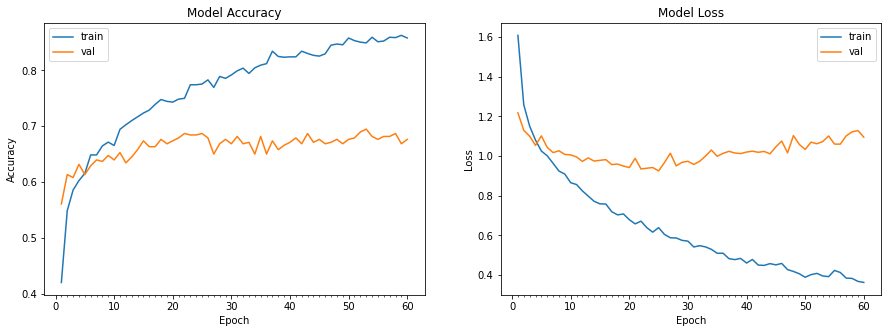

In [34]:
plot_model_history(history)